In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load CMS exclusion curve

In [2]:
cmsData = pd.read_pickle('../AuxInfo/CMS-EXO-20-004-data/DMsimp_spin-0_Monojet_DF.pcl')
cmsCurve = np.genfromtxt('../AuxInfo/CMS-EXO-20-004-data/HEPData-ins1894408-v2-csv/Signalstrengthlimits,pseudoscalarmediator.csv',
                        skip_header=14,names=True,delimiter=',',skip_footer=60)

### Load Recast Data

In [3]:
recastData = pd.read_pickle('../scanResults_pseudoscalar.pcl')

In [4]:
cmsData['$\\mu^{UL}_{exp}$'].max()

135.59329846504284

In [5]:
recastData['$\\mu^{UL}_{exp}$'].max()

278308.14411861217

In [6]:
recastData.T

,0,1,2,3,4,5,6,7,8,9,...,512,513,514,515,516,517,518,519,520,521
Coupling,Scalar,Scalar,Scalar,Scalar,Scalar,Scalar,Scalar,Scalar,Scalar,Scalar,...,Scalar,Scalar,Scalar,Scalar,Scalar,Scalar,Scalar,Scalar,Scalar,Scalar
Mode,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,...,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets
$m_{med}$,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
$m_{DM}$,30.0,30.0,30.0,40.0,40.0,40.0,45.0,45.0,45.0,55.0,...,200.0,400.0,400.0,400.0,600.0,600.0,600.0,800.0,800.0,800.0
Data-takingperiod,2018,2017,2016,2018,2017,2016,2018,2017,2016,2018,...,2016,2018,2017,2016,2018,2017,2016,2018,2017,2016
Luminosity (1/fb),59.7,41.5,36.0,59.7,41.5,36.0,59.7,41.5,36.0,59.7,...,36.0,59.7,41.5,36.0,59.7,41.5,36.0,59.7,41.5,36.0
bin_250.0_280.0,3637.3106,3211.472208,2768.469937,3774.886478,3220.394014,2774.834964,4041.188348,3249.579678,2893.955685,252.661927,...,0.136596,0.15814,0.15278,0.129687,0.133038,0.112286,0.103547,0.098359,0.087567,0.079091
bin_250.0_280.0_ErrorPlus,114.64271,113.131789,97.636529,118.408711,109.935982,97.869063,127.524557,110.413628,104.832777,9.425755,...,0.006826,0.006833,0.006715,0.006162,0.005738,0.005303,0.005079,0.004331,0.004126,0.003918
bin_250.0_280.0_ErrorMinus,114.64271,113.131789,97.636529,118.408711,109.935982,97.869063,127.524557,110.413628,104.832777,9.425755,...,0.006826,0.006833,0.006715,0.006162,0.005738,0.005303,0.005079,0.004331,0.004126,0.003918
bin_280.0_310.0,2310.61234,2169.575281,1835.936587,2286.081788,2198.960529,1773.905971,2418.088502,2148.287646,1817.503686,174.907247,...,0.128121,0.138796,0.121433,0.103071,0.112117,0.097721,0.087608,0.090118,0.077486,0.067072


### Get all model points

In [7]:
models = []
mCols = ['Coupling','Mode','$m_{med}$','$m_{DM}$','$g_{DM}$', '$g_{q}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols,row.tolist()))
    if m not in models:
        models.append(m)
print('%i models loaded' %len(models))

174 models loaded


### Get model parameters

In [8]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': 'Scalar', 'Mode': 'DM+QCDjets', '$m_{med}$': [450.0, 1250.0, 100.0, 2500.0, 200.0, 1000.0, 2250.0, 300.0, 750.0, 400.0, 2000.0, 500.0, 1750.0, 3000.0, 250.0, 1500.0, 2750.0], '$m_{DM}$': [1.0, 900.0, 1400.0, 650.0, 400.0, 150.0, 30.0, 800.0, 40.0, 300.0, 45.0, 1200.0, 50.0, 55.0, 700.0, 60.0, 450.0, 70.0, 200.0, 75.0, 1100.0, 80.0, 600.0, 90.0, 1500.0, 350.0, 100.0, 1000.0, 750.0, 500.0, 120.0, 250.0], '$g_{DM}$': 1.0, '$g_{q}$': 1.0}
Coupling = Scalar
Mode = DM+QCDjets
$g_{DM}$ = 1.0
$g_{q}$ = 1.0


In [9]:
# Remove duplicated data from other datasets
recastData = recastData[recastData['Data-takingperiod'] == 2017]
cmsData = cmsData[cmsData['Data-takingperiod'] == 2017]

In [10]:
kfactor = 1.
lmuData = np.log10(recastData['$\\mu^{UL}_{obs}$']/kfactor)

In [11]:
lmuData.max()

5.0004177191103345

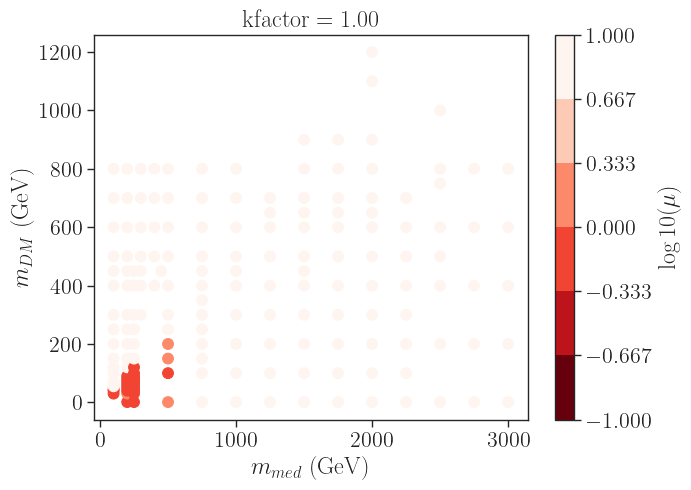

In [12]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=recastData['$m_{med}$'], y=recastData['$m_{DM}$'], vmin=-1., vmax=1.,
            c=lmuData, cmap=plt.cm.get_cmap('Reds_r', 6), s=60)

cbar = plt.colorbar(label=r'$\log10(\mu)$')
cbar.set_ticks([-1., -0.6666, -0.3333, 0., 0.3333, 0.6666, 1.])
plt.xlabel(r'$m_{med}$ (GeV)')
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10, 400)
# plt.xlim(0, 1000)
plt.title('kfactor = %1.2f' %kfactor)
plt.show()

In [13]:
pts = np.array([x for x in product(np.linspace(0,2500.,100),np.linspace(0,1500.,100))])
lmuPts = griddata(list(zip(recastData['$m_{med}$'],recastData['$m_{DM}$'])), lmuData, pts)
pts = pts[~np.isnan(lmuPts)]
lmuPts = lmuPts[~np.isnan(lmuPts)]

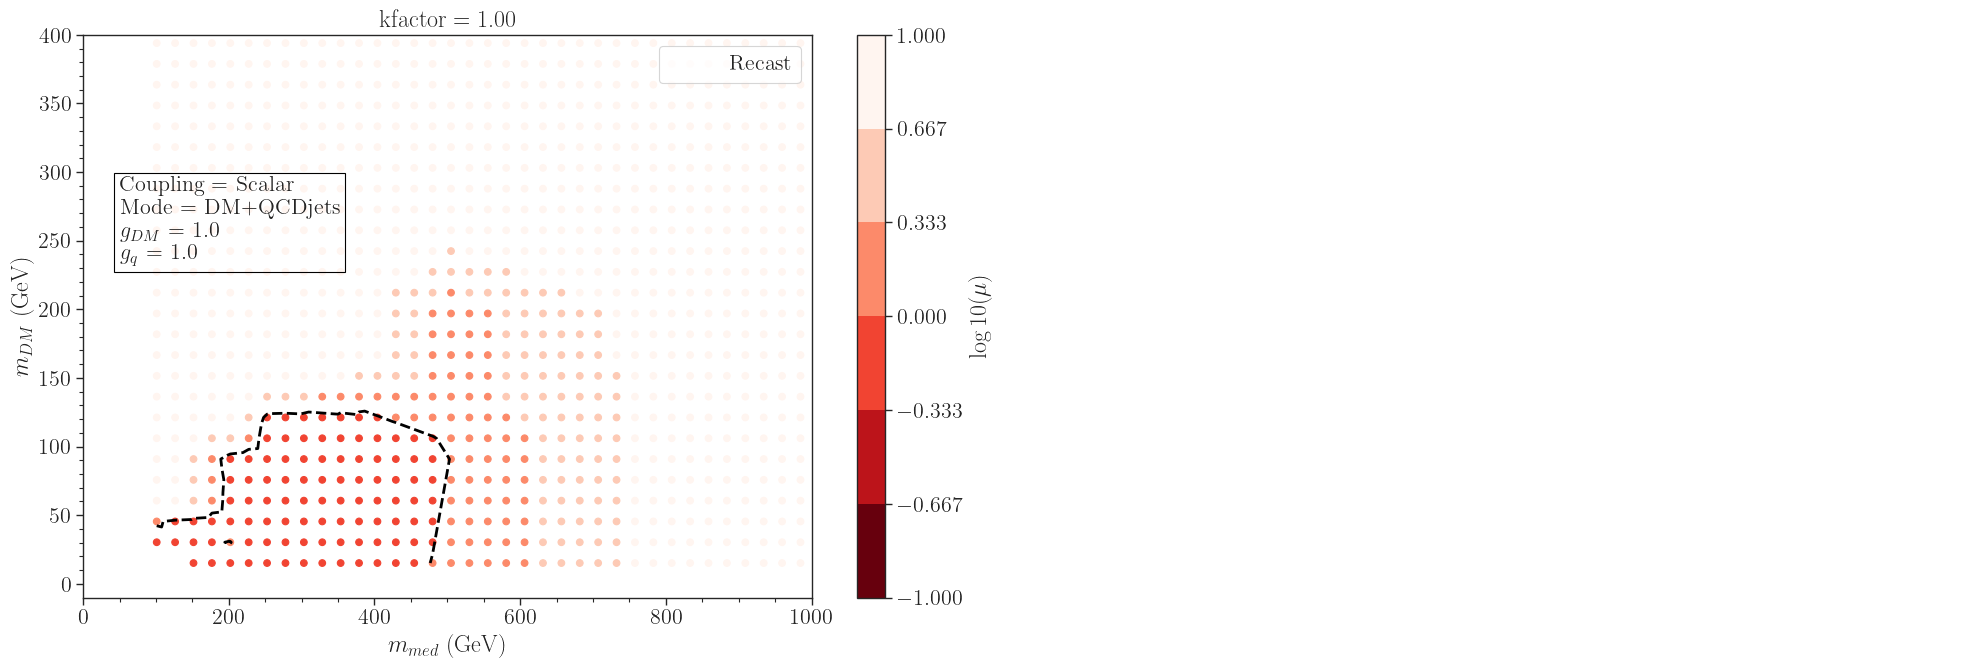

In [14]:
fig,ax = plt.subplots(figsize=(20,7),ncols=2,nrows=1)


p = ax[0].scatter(x=pts[:,0],y=pts[:,1],vmin=-1.0,vmax=1.0,
            c=lmuPts,cmap=plt.cm.get_cmap('Reds_r', 6))
cbar = plt.colorbar(p,label=r'$\log10(\mu)$',ax=ax[0])
cbar.set_ticks([-1.0,-0.6666,-0.3333,0.0,0.33333,0.66666,1.0])
cs = ax[0].tricontour(pts[:,0],pts[:,1],lmuPts,levels=[0.0],
               linewidths=2,linestyles='dashed',colors='black')
cs.collections[0].set_label('Recast')


ax[0].legend(loc='upper right')
ax[0].set_xlabel(r'$m_{med}$ (GeV)')
ax[0].set_ylabel(r'$m_{DM}$ (GeV)')
ax[0].set_ylim(-10,400)
ax[0].set_xlim(0,1000)
ax[0].minorticks_on()
ax[0].text(0.05,0.6,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = ax[0].transAxes)
ax[0].set_title('kfactor = %1.2f' %kfactor)

# cmsPlot = plt.imread('../AuxInfo/CMS-EXO-20-004-data/CMS-EXO-20-004_Figure_021.png')
# ax[1].imshow(cmsPlot)
ax[1].axis('off')
plt.tight_layout()
plt.show()

### Get all model points with common models to CMS data

In [11]:
keys = list(cmsData[mCols].columns.values)
i1 = recastData.set_index(keys).index
i2 = cmsData.set_index(keys).index
recastData = recastData[i1.isin(i2)]
cmsData = cmsData[i2.isin(i1)]
print(len(recastData),len(cmsData))

7 7


In [12]:
recastData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)  
cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)                

### Add ratio of upper limits for the common points

In [13]:
kfactor = 0.85
recastData['UL ratio'] = (recastData['$\mu^{UL}_{obs}$']/kfactor)/cmsData['$\mu^{UL}_{obs}$']

In [13]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=recastData['$m_{med}$'],y=recastData['$m_{DM}$'],vmin=0.,vmax=1.3,
            c=recastData['UL ratio'],cmap=plt.cm.get_cmap('RdYlBu'),s=100)
cbar = plt.colorbar(label=r'$\mu^{Recast}_{UL}/\mu^{CMS}_{UL}$')
# cbar.set_ticks([0.5,0.75,0.9,1.0,1.1,1.25,1.5])

plt.xlabel(r'$m_{med}$ (GeV)')
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
# plt.yscale('log')
plt.title('kfactor = %1.2f' %kfactor)
plt.show()

KeyError: 'UL ratio'

<Figure size 700x500 with 0 Axes>

### Get all model points with mDM = 1 GeV

In [15]:
recastData = recastData[(recastData['$m_{DM}$'] == 1.0)]
cmsData = cmsData[(cmsData['$m_{DM}$'] == 1.0)]

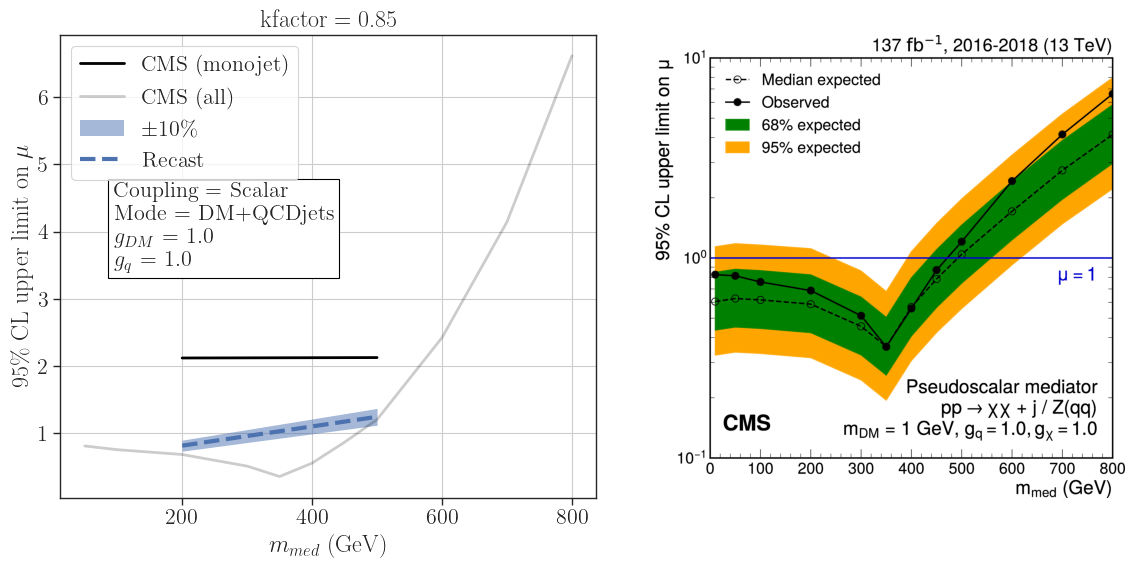

In [16]:
fig,ax = plt.subplots(figsize=(12,6),ncols=2,nrows=1)
ax[0].plot(cmsData['$m_{med}$'],cmsData['$\mu^{UL}_{obs}$'],label='CMS (monojet)',linewidth=2,color='black')

ax[0].plot(cmsCurve['m_med_GeV'],cmsCurve['Signal_strength_limit'],label='CMS (all)',
         linewidth=2,color='black',alpha=0.2)

ax[0].fill_between(recastData['$m_{med}$'],1.1*recastData['$\mu^{UL}_{obs}$']/kfactor,
                 0.9*recastData['$\mu^{UL}_{obs}$']/kfactor,
                alpha=0.5,linewidth=0,label=r'$\pm 10$\%' )
    
ax[0].plot(recastData['$m_{med}$'],recastData['$\mu^{UL}_{obs}$']/kfactor,
         linestyle='--',label='Recast',linewidth=3,markersize=7)
    

# plt.hlines(y=1.0,xmin=modelData['$m_{med}$'].min(),xmax=modelData['$m_{med}$'].max(),color='blue')
ax[0].set_xlabel(r'$m_{med}$ (GeV)')
ax[0].set_ylabel(r'95\% CL upper limit on $\mu$')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
ax[0].set_title('kfactor = %1.2f' %kfactor)
ax[0].text(0.1,0.5,textstr,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = ax[0].transAxes)
ax[0].legend()
ax[0].grid()

cmsPlot = plt.imread('../AuxInfo/CMS-EXO-20-004-data/CMS-EXO-20-004_Figure_009-b.png')
ax[1].imshow(cmsPlot)
ax[1].axis('off')

plt.tight_layout()
plt.show()